# Intro to Stats Learning

## Lab 3 - Linear Regression

In [1]:
using Pkg; Pkg.activate("D:/JULIA/6_ML_with_Julia/ISL-lab-3"); Pkg.instantiate()

  Activating project at `D:\JULIA\6_ML_with_Julia\ISL-lab-3`


> Simple linear regression
> <br> Interaction and transformation

### Simple linear regression

---

```MLJ``` essentially serves as a unified path to many existing Julia packages each of which provides their own functionalities and models, with their own conventions.

The simple linear regression demonstrates this. Several packages offer it (beyond just using the backslash operator): here we will use ```MLJLinearModels``` but we could also have used GLM, ```ScikitLearn``` etc.

To load the model from a given package use ```@load ModelName pkg=PackageName```

In [2]:
using MLJ

LinearRegressor = @load LinearRegressor pkg=MLJLinearModels

┌ Info: For silent loading, specify `verbosity=0`. 
└ @ Main C:\Users\jeffr\.julia\packages\MLJModels\tMgLW\src\loading.jl:168


import MLJLinearModels ✔


MLJLinearModels.LinearRegressor

Note: in orderto be able to load this, you **must** have the relevant package in your environment, if you don't, you can always add it(```using Pkg; Pkg.add("MLJLinearModels")```).

Let's load the boston data set

```R
Housing Values in Suburbs of Boston
Description
The Boston data frame has 506 rows and 14 columns.

Usage
Boston
Format
This data frame contains the following columns:

crim
per capita crime rate by town.

zn
proportion of residential land zoned for lots over 25,000 sq.ft.

indus
proportion of non-retail business acres per town.

chas
Charles River dummy variable (= 1 if tract bounds river; 0 otherwise).

nox
nitrogen oxides concentration (parts per 10 million).

rm
average number of rooms per dwelling.

age
proportion of owner-occupied units built prior to 1940.

dis
weighted mean of distances to five Boston employment centres.

rad
index of accessibility to radial highways.

tax
full-value property-tax rate per $10,000.

ptratio
pupil-teacher ratio by town.

black
1000(Bk - 0.63)^21000(Bk−0.63) 
2
  where BkBk is the proportion of blacks by town.

lstat
lower status of the population (percent).

medv
median value of owner-occupied homes in $1000s.
```

In [3]:
import RDatasets: dataset
import DataFrames: describe, select, Not, rename!
boston = dataset("MASS", "Boston")
first(boston, 3)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad,Tax
,Float64,Float64,Float64,Int64,Float64,Float64,Float64,Float64,Int64,Int64
1,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.09,1,296
2,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242
3,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242


Let's get a feel for the data

In [4]:
describe(boston, :mean, :std, :eltype)

,variable,mean,std,eltype
,Symbol,Float64,Float64,DataType
1,Crim,3.61352,8.60155,Float64
2,Zn,11.3636,23.3225,Float64
3,Indus,11.1368,6.86035,Float64
4,Chas,0.06917,0.253994,Int64
5,NOx,0.554695,0.115878,Float64
6,Rm,6.28463,0.702617,Float64
7,Age,68.5749,28.1489,Float64
8,Dis,3.79504,2.10571,Float64
9,Rad,9.54941,8.70726,Int64


So there's no missing value and most variables are encoded as floating point numbers. In MLJ it's important to specify the interpretation of the features (should it be considered as a Continuous feature, as a Count, ...?), see also this tutorial section on scientific types.

Here we will just interpret the integer features as continuous as we will just use a basic linear regression:

In [5]:
data = coerce(boston, autotype(boston, :discrete_to_continuous));

In [6]:
describe(data)

,variable,mean,min,median,max,nmissing,eltype
,Symbol,Float64,Float64,Float64,Float64,Int64,DataType
1,Crim,3.61352,0.00632,0.25651,88.9762,0,Float64
2,Zn,11.3636,0.0,0.0,100.0,0,Float64
3,Indus,11.1368,0.46,9.69,27.74,0,Float64
4,Chas,0.06917,0.0,0.0,1.0,0,Float64
5,NOx,0.554695,0.385,0.538,0.871,0,Float64
6,Rm,6.28463,3.561,6.2085,8.78,0,Float64
7,Age,68.5749,2.9,77.5,100.0,0,Float64
8,Dis,3.79504,1.1296,3.20745,12.1265,0,Float64
9,Rad,9.54941,1.0,5.0,24.0,0,Float64


In [7]:
schema(data)

┌─────────┬────────────┬─────────┐
│ names   │ scitypes   │ types   │
├─────────┼────────────┼─────────┤
│ Crim    │ Continuous │ Float64 │
│ Zn      │ Continuous │ Float64 │
│ Indus   │ Continuous │ Float64 │
│ Chas    │ Continuous │ Float64 │
│ NOx     │ Continuous │ Float64 │
│ Rm      │ Continuous │ Float64 │
│ Age     │ Continuous │ Float64 │
│ Dis     │ Continuous │ Float64 │
│ Rad     │ Continuous │ Float64 │
│ Tax     │ Continuous │ Float64 │
│ PTRatio │ Continuous │ Float64 │
│ Black   │ Continuous │ Float64 │
│ LStat   │ Continuous │ Float64 │
│ MedV    │ Continuous │ Float64 │
└─────────┴────────────┴─────────┘


Let's also extract the target variable (```MedV```):

In [8]:
y = data.MedV
X = select(data, Not(:MedV));

Let's declare a simple multivariate linear regression model:

In [9]:
mdl = LinearRegressor()

LinearRegressor(
    fit_intercept = true,
    solver = nothing)

First let's do a very simple univariate regression, in order to fit it on the data, we need to wrap it in a machine which, in MLJ, is the composition of a model and data to apply the model on:

In [10]:
X_uni = select(X, :LStat) # only a single feature
mach_uni = machine(mdl, X_uni, y)

Machine{LinearRegressor,…} trained 0 times; caches data
  model: MLJLinearModels.LinearRegressor
  args: 
    1:	Source @713 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @533 ⏎ `AbstractVector{Continuous}`


Fitting the model using ```Fit!``` function

In [11]:
fit!(mach_uni)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


Machine{LinearRegressor,…} trained 1 time; caches data
  model: MLJLinearModels.LinearRegressor
  args: 
    1:	Source @713 ⏎ `Table{AbstractVector{Continuous}}`
    2:	Source @533 ⏎ `AbstractVector{Continuous}`


You can then retrieve the fitted parameters using ```fitted_params```:

In [12]:
fp = fitted_params(mach_uni)

(coefs = [:LStat => -0.9500493537579906],
 intercept = 34.553840879383095,)

In [13]:
@show fp.coefs
@show fp.intercept;

fp.coefs = [:LStat => -0.9500493537579906]
fp.intercept = 34.553840879383095


You can also visualize this

┌ Warning: `vendor()` is deprecated, use `BLAS.get_config()` and inspect the output instead
│   caller = npyinitialize() at numpy.jl:67
└ @ PyCall C:\Users\jeffr\.julia\packages\PyCall\L0fLP\src\numpy.jl:67


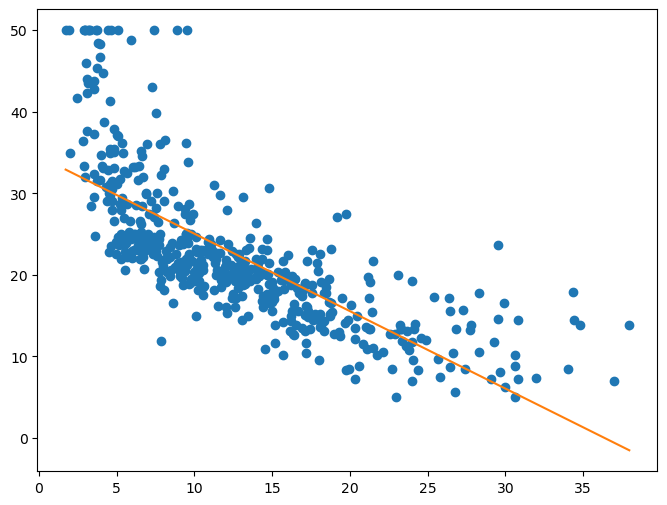

In [14]:
using PyPlot

figure(figsize=(8, 6))
plot(X.LStat, y, ls = "none", marker = "o")
Xnew = (LStat = collect(range(extrema(X.LStat)..., length = 100 )), )
plot(Xnew.LStat, MLJ.predict(mach_uni, Xnew))
savefig("./plots/3.2.1.png")

The multivariate case is very similar

In [15]:
mach = machine(mdl, X, y)
fit!(mach)

fp = fitted_params(mach)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


(coefs = [:Crim => -0.10801135783679668, :Zn => 0.04642045836688126, :Indus => 0.02055862636707102, :Chas => 2.686733819344888, :NOx => -17.766611228300157, :Rm => 3.809865206809212, :Age => 0.0006922246403444266, :Dis => -1.4755668456002555, :Rad => 0.306049478985174, :Tax => -0.01233459391657447, :PTRatio => -0.9527472317072884, :Black => 0.009311683273793812, :LStat => -0.5247583778554896],
 intercept = 36.45948838508996,)

In [16]:
coefs = fp.coefs
intercept = fp.intercept
for (name, val) in coefs
    println("$(rpad(name, 9)): $(round(val, sigdigits = 3))")
end 
println("Intercept: $(round(intercept, sigdigits = 3))")

Crim     : -0.108
Zn       : 0.0464
Indus    : 0.0206
Chas     : 2.69
NOx      : -17.8
Rm       : 3.81
Age      : 0.000692
Dis      : -1.48
Rad      : 0.306
Tax      : -0.0123
PTRatio  : -0.953
Black    : 0.00931
LStat    : -0.525
Intercept: 36.5


In [17]:
lpad("March", 10)

"     March"

In [18]:
rpad("March", 20)

"March               "

You can use the ```machine``` in order to predict values as well and, for instance, compute the root mean squared error:

In [19]:
ŷ = MLJ.predict(mach, X)
round(rms(ŷ, y), sigdigits = 4)

4.679

Let's see what the residuals look like

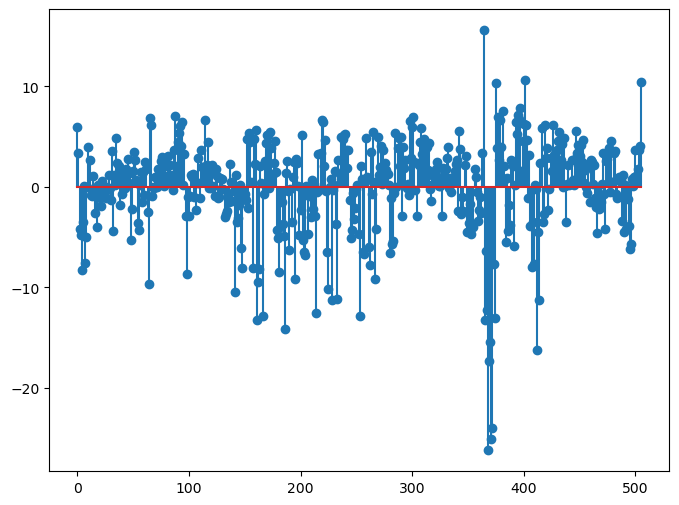

In [20]:
figure(figsize=(8,6))
res = ŷ .- y
stem(res)
savefig("./plots/3.2.2.png")

> (stem plot) https://winston.readthedocs.io/en/latest/fun/stem.html

Maybe that a histogram is more appropriate here

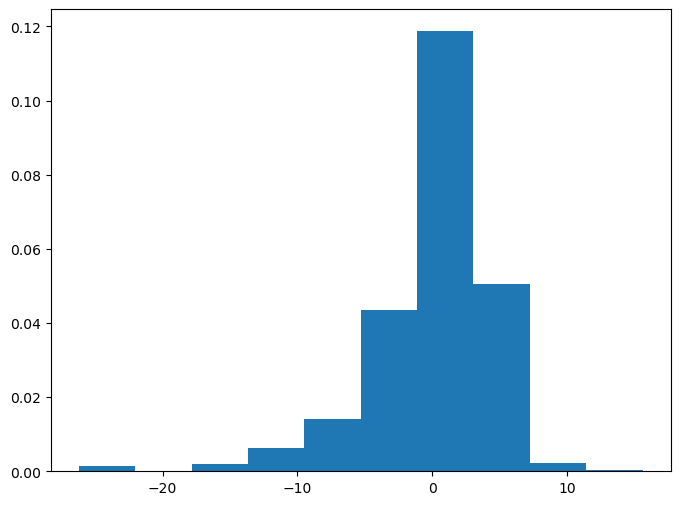

In [21]:
figure(figsize = (8,6))
hist(res, density = true)
savefig("./plots/3.2.3.png")

### Interaction and transformation

---

Let's say we want to also consider an interaction term of ```lstat``` and ```age``` taken together. To do this, just create a new dataframe with an additional column corresponding to the interaction term:

In [22]:
X2 = hcat(X, X.LStat .* X.Age)

,Crim,Zn,Indus,Chas,NOx,Rm,Age,Dis,Rad
,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64,Float64
1,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.09,1.0
2,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0
3,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0
4,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0
5,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0
6,0.02985,0.0,2.18,0.0,0.458,6.43,58.7,6.0622,3.0
7,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0
8,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0
9,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0


In [23]:
names(X2)

14-element Vector{String}:
 "Crim"
 "Zn"
 "Indus"
 "Chas"
 "NOx"
 "Rm"
 "Age"
 "Dis"
 "Rad"
 "Tax"
 "PTRatio"
 "Black"
 "LStat"
 "x1"

새로운 컬럼이 x1으로 생성됨 -> 이름 변경 

So here we have a DataFrame with one extra column corresponding to the elementwise products between :LStat and Age. DataFrame gives this a default name (:x1) which we can change:

In [24]:
rename!(X2, :x1 => :interaction);

In [25]:
names(X2)

14-element Vector{String}:
 "Crim"
 "Zn"
 "Indus"
 "Chas"
 "NOx"
 "Rm"
 "Age"
 "Dis"
 "Rad"
 "Tax"
 "PTRatio"
 "Black"
 "LStat"
 "interaction"

Ok cool, now let's try the linear regression again

In [26]:
mach = machine(mdl, X2, y)
fit!(mach)
ŷ = MLJ.predict(mach, X2)
round(rms(ŷ, y), sigdigits = 4)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


4.676

We get slightly better results but nothing spectacular.

Let's get back to the lab where they consider regressing the target variable on ```lstat``` and ```lstat^2```; again, it's essentially a case of defining the right DataFrame:

In [27]:
X3 = hcat(X.LStat, X.LStat.^2) |> MLJ.table
mach = machine(mdl, X3, y)
fit!(mach)
ŷ = MLJ.predict(mach, X3)
round(rms(ŷ, y), sigdigits = 4)

┌ Info: Training Machine{LinearRegressor,…}.
└ @ MLJBase C:\Users\jeffr\.julia\packages\MLJBase\MuLnJ\src\machines.jl:464


5.507

which again, we can visualise:

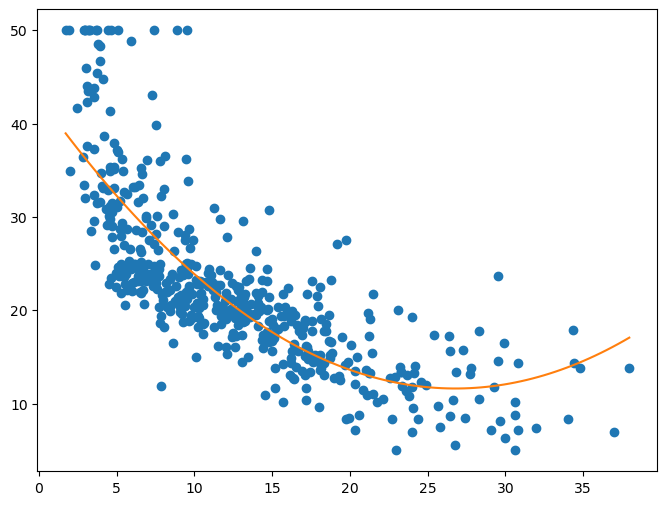

In [28]:
Xnew = (LStat = Xnew.LStat, LStat2 = Xnew.LStat.^2)

figure(figsize = (8, 6))
plot(X.LStat, y, ls = "none", marker = "o")
plot(Xnew.LStat, MLJ.predict(mach, Xnew))
savefig("./plots/3.2.4.png")

In [29]:
Xnew.LStat

100-element Vector{Float64}:
  1.73
  2.096060606060606
  2.462121212121212
  2.828181818181818
  3.1942424242424243
  3.5603030303030305
  3.9263636363636363
  4.292424242424242
  4.658484848484848
  5.024545454545454
  5.390606060606061
  5.756666666666667
  6.122727272727273
  ⋮
 33.943333333333335
 34.30939393939394
 34.67545454545454
 35.04151515151515
 35.407575757575756
 35.77363636363636
 36.13969696969697
 36.50575757575758
 36.871818181818185
 37.237878787878785
 37.60393939393939
 37.97

In [30]:
collect(range(extrema(X.LStat)..., length = 100 ))

100-element Vector{Float64}:
  1.73
  2.096060606060606
  2.462121212121212
  2.828181818181818
  3.1942424242424243
  3.5603030303030305
  3.9263636363636363
  4.292424242424242
  4.658484848484848
  5.024545454545454
  5.390606060606061
  5.756666666666667
  6.122727272727273
  ⋮
 33.943333333333335
 34.30939393939394
 34.67545454545454
 35.04151515151515
 35.407575757575756
 35.77363636363636
 36.13969696969697
 36.50575757575758
 36.871818181818185
 37.237878787878785
 37.60393939393939
 37.97

In [31]:
extrema(X.LStat)

(1.73, 37.97)

In [32]:
range(extrema(X.LStat)..., length = 100 )

1.73:0.3660606060606061:37.97